# DSCI 100-004: Group 19 Project

Aadeesh Nargotra, Hongwei Wang, Joshua Tan, Nayeon Lee

## Table of Contents:
* [Introduction](#introduction)
    * [Background and significance](*background)
* [Methods: Cleaning and Exploring the Data](#methods)
    * [Installing and loading the required packages](#installing)
    * [Reading the airplane dataset](#reading)
    * [Reducing the size of the dataset](#reducing)
    * [Cleaning airplane_data](#cleaning)
    * [Splitting airplane_cleaned_data into training and test sets](#splitting)
* [Methods: Tuning and Evaluating the Classifier]
* [Methods: Predicting Satisfaction from the Test Set] 

## Introduction <a name="introduction"></a>

### Background and significance <a name="background"></a>

Airlines regularly receive feedback from customers who utilize their planes based on their experience. A major responsibility of airlines when it comes to providing amenities is to ensure that customers have the best possible experience while flying. By identifying areas for improvement, airlines would be able to better understand customer needs, thereby increasing customer retention. We will be answering our predictive question, “can we predict the next customer’s satisfaction as satisfied or dissatisfied based on the airplane satisfaction data?”  The factors that can determine our classification include, departure/arrival delays, gate location, online boarding, inflight entertainment, legroom service, check-in service, inflight wifi service, food and drink, seat comfort, on-board service baggage handling, and cleanliness. We will be utilizing ‘Airline Passenger Satisfaction’ dataset by T.J. Klein on Kagle. https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data

<mark>TODO: Add information about what the dataset includes. (I.e., what each column has)<mark>

<mark>TODO: Perhaps add citations here?<mark>


## Methods <a name="methods"></a>

### Installing and loading the required packages <a name="installing"></a>

In [111]:
install.packages("janitor")
install.packages("kknn")
install.packages("gridExtra")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [112]:
library(tidyverse)
library(janitor)
library(tidymodels)
library(gridExtra)
library(kknn)
library(repr)

### Reading the airplane dataset <a name="reading"></a>

The airplane data that was downloaded from Kaggle was already split into a test and training set. Specifcially, the dataset was split such that 20% of the data was in the testing set and 80% was in the training set. 

In [113]:
test_set <- read_csv("Airplane Data/test.csv") 
train_set <- read_csv("Airplane Data/train.csv")

New names:
• `` -> `...1`
Rows: 25976 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Gender, Customer Type, Type of Travel, Class, satisfaction
dbl (20): ...1, id, Age, Flight Distance, Inflight wifi service, Departure/A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 103904 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Gender, Customer Type, Type of Travel, Class, satisfaction
dbl (20): ...1, id, Age, Flight Distance, Inflight wifi service, Departure/A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Reducing the size of the dataset <a name="reducing"></a>

As specified by the output after using `read_csv()` on both sets, the dataset is extremely large with 129,880 total observations and 25 columns. As such, our TA advised us to reduce the dataset into 1/5th of it's original size. To accomplish this, we combined the test and training datasets using `rbind()` and used the `slice()` function to only keep every 5th observation.

In [114]:
airplane_data <- rbind(test_set, train_set)
airplane_data <- airplane_data |>
              slice(seq(from = 1, to = 129880, by = 5))
nrow(airplane_data)

[1] 25976

Using `nrow()` confirms that our dataset now has 25976 observations compared to the 129,880 observations we previously had.

### Cleaning airplane_data <a name="cleaning"></a>

In [115]:
head(airplane_data)

...1 id    Gender Customer Type  Age Type of Travel  Class    Flight Distance
1  0   19556 Female Loyal Customer 52  Business travel Eco       160           
2  5   39177 Male   Loyal Customer 16  Business travel Eco       311           
3 10   47583 Female Loyal Customer 47  Business travel Eco      1235           
4 15   22470 Male   Loyal Customer 50  Personal Travel Eco        83           
5 20   63995 Male   Loyal Customer 60  Business travel Business  612           
6 25    7823 Male   Loyal Customer 62  Personal Travel Eco       710           
  Inflight wifi service Departure/Arrival time convenient ⋯
1 5                     4                                 ⋯
2 3                     3                                 ⋯
3 4                     1                                 ⋯
4 3                     4                                 ⋯
5 4                     4                                 ⋯
6 3                     5                                 ⋯
  Inflight entertainment On-board service Leg room service Baggage handling
1 5                      5                5                5               
2 5                      4                3                1               
3 3                      3                4                3               
4 2                      4                2                4               
5 5                      5                5                5               
6 2                      3                5                5               
  Checkin service Inflight service Cleanliness Departure Delay in Minutes
1 2               5                5           50                        
2 1               2                5            0                        
3 1               3                4           29                        
4 4               5                2            5                        
5 5               5                5           21                        
6 4               4                2            0                        
  Arrival Delay in Minutes satisfaction           
1 44                       satisfied              
2  0                       satisfied              
3 19                       satisfied              
4  2                       neutral or dissatisfied
5 49                       satisfied              
6  0                       neutral or dissatisfied

<font size= '2'> **Table 1:** Using `head()` on our reduced airplane dataset reveals information about the column names and their datatypes

Now that the data set is more manageable, we began cleaning our data to prepare for it for analysis. Upon using `head()`, we noticed that the columns weren't in a clean format. Thus, we used the `clean_names()` function to make the column names into snake_case.

Next, we needed to remove unnecessary columns that we knew we would not need for our knn analysis. Specifically, we removed the `...1` and `id` columns as they were arbitrary passenger identifiers. We also removed the `Gender`, `Customer Type`, `Age`, `Type of Travel`, and `Class` columns as they are not numerical and thus would not be used for the knn analysis. Finally, we removed `Flight Distance` as we felt that it was not as relevant to a passenger's overall satisfaction. Indeed, the flight distance is a variable that airlines cannot improve upon as it is simply out of their control.

We assigned all these changes to a new variable called `airplane_data_cleaned`.

In [116]:
airplane_data_cleaned <- airplane_data |>
              clean_names() |>
              select(9:25)

Additionally, as the data set was too big to visually see if there were any missing data (i.e., NAs), we used the `map_df()` function to create a summary table of any NA's in a given column.

In [117]:
map_df(airplane_data_cleaned, ~sum(is.na(.))) 

inflight_wifi_service departure_arrival_time_convenient
1 0                     0                                
  ease_of_online_booking gate_location food_and_drink online_boarding
1 0                      0             0              0              
  seat_comfort inflight_entertainment on_board_service leg_room_service
1 0            0                      0                0               
  baggage_handling checkin_service inflight_service cleanliness
1 0                0               0                0          
  departure_delay_in_minutes arrival_delay_in_minutes satisfaction
1 0                          75                       0

<font size= '2'> **Table 2:** A summary table of the number of missing data in each column.

The `map_df()` function revealed that there were 75 NA's in the `arrival_delay_in_minutes` column. Because there were only a few rows with missing data (i.e., 75 rows), we felt comfortable dropping them as they likely wouldn't affect our k-nn analysis. As such, we used the `drop_na` function to remove the rows with an NA in the `arrival_delay_in_minutes` column.

In [118]:
airplane_data_cleaned <- airplane_data_cleaned |> drop_na()
as_tibble(sum(is.na(airplane_data_cleaned))) |> 
    rename(total_na = value)
nrow(airplane_data_cleaned)

total_na
1 0

[1] 25901

<font size= '2'> **Table 3:** Using the `as_tibble` function in conjunction with`sum(is.na()` and `rename()` created a table of the total NA's in our dataset. As expected, there are now zero NA's in our data set. Additionally, `nrow()` reveals that our dataset has been reduced from 25976 rows to 25901 rows—consistent with the removal of the 75 rows with NA's.

Finally, given that we want to predict the `satisfaction` label of a given observation, we converted the `satisfacation` column from a character class to the factor datatype.

In [119]:
airplane_data_cleaned <- airplane_data_cleaned|> 
                      mutate(satisfaction = as_factor(satisfaction))
class(airplane_data_cleaned$satisfaction)

[1] "factor"

The `class` function confirms that the `satisfaction` column is now a factor datatype.

### Splitting airplane_cleaned_data into training and test sets <a name="splitting"></a>

Once the airplane data set was cleaned, we split it into our training and test sets using the `initial_split()` function. By setting the `strata` argument to `satisfaction`, we ensure that the data is stratified by the `satisfaction` variable. Furthermore, setting `prop = 0.75` ensures that 75% of the original data set ends up in the training set. In addition, `initial_split()` ensures that the proportions between observations that are either a) satisfied or b) neutral or dissatisfied are the same for both training and test sets. 

We assigned the training and test sets to `airplane_train` and `airplane_test`, respectively.

In [120]:
set.seed(1234)

airplane_split <- initial_split(airplane_data_cleaned, prop = 0.75, strata = satisfaction)
airplane_train <- training(airplane_split)
airplane_test <- testing(airplane_split)

### Exploring the training set

As part of the exploratory data analysis, we calculated the count and percentage of satisfied and netural or dissatisfied observations in the training set. To accomplish this, we used the `group_by()` function in conjunction with`summarize()`. 

In [121]:
num_obs <- nrow(airplane_train)
airplane_train |> 
    group_by(satisfaction) |>
    summarize(
            count = n(),
            percentage = n() / num_obs * 100
              )

satisfaction            count percentage
1 satisfied                8380 43.14028  
2 neutral or dissatisfied 11045 56.85972

<font size= '2'> **Table 4:** The count and percentage of observations in the training set grouped by satisfaction.

The above table reveals that we have 8380 (~ 43.14%) observations that were classified as satisfied and 11045 (~ 56.86%) that were classified as neutral or dissatisfied. Indeed, it looks like there are slightly more passengers who are neutral or dissatisfied with their airline experience compared to passengers who are satisfied.

Furthermore, we examined the means of each potential predictor variable. Aside from `departure_delay_in_minutes` and `arrival_delay_in_minutes`, each variable is discrete and includes each passenger's satisfaction level for a given airline service on a scale of 1-5. Thus, a higher mean would indicate that many passengers were highly satisfied with the service. This information helped with deciding which predictor variable to include in our knn analysis because if more people were satisfied with one service compared to another, that might play a larger role in whether they were classified as `satisfied` or `neutral or dissatisfied`.

To find the means, we used the `map_df()` function and `pivot_longer()` to create a column for the variable name and another column with the variable's respective mean. We then used `arranged(desc(mean))` to arrange the dataframe by the mean.

In [122]:
airplane_means <- airplane_train |>
    select(-satisfaction) |>
    map_df(mean) |>
    select(-departure_delay_in_minutes, -arrival_delay_in_minutes) |>
    pivot_longer(1:14, names_to = "variable", values_to = "mean") |>
    arrange(desc(mean))

airplane_means

variable                          mean    
1  inflight_service                  3.636036
2  baggage_handling                  3.627490
3  seat_comfort                      3.436808
4  on_board_service                  3.383938
5  inflight_entertainment            3.357220
6  leg_room_service                  3.339356
7  checkin_service                   3.295959
8  cleanliness                       3.283552
9  online_boarding                   3.243501
10 food_and_drink                    3.206795
11 departure_arrival_time_convenient 3.042831
12 gate_location                     2.982548
13 ease_of_online_booking            2.745431
14 inflight_wifi_service             2.719279

<font size= '2'> **Table 5:** The means of each discrete predictor variable arranged in descending order by mean

A bar plot can be used to visually see the difference in means between the discrete predictors. We did this by using the `ggplot()` function with `geom_bar`. teh variables are ordered left to right in descending order based on their mean. 

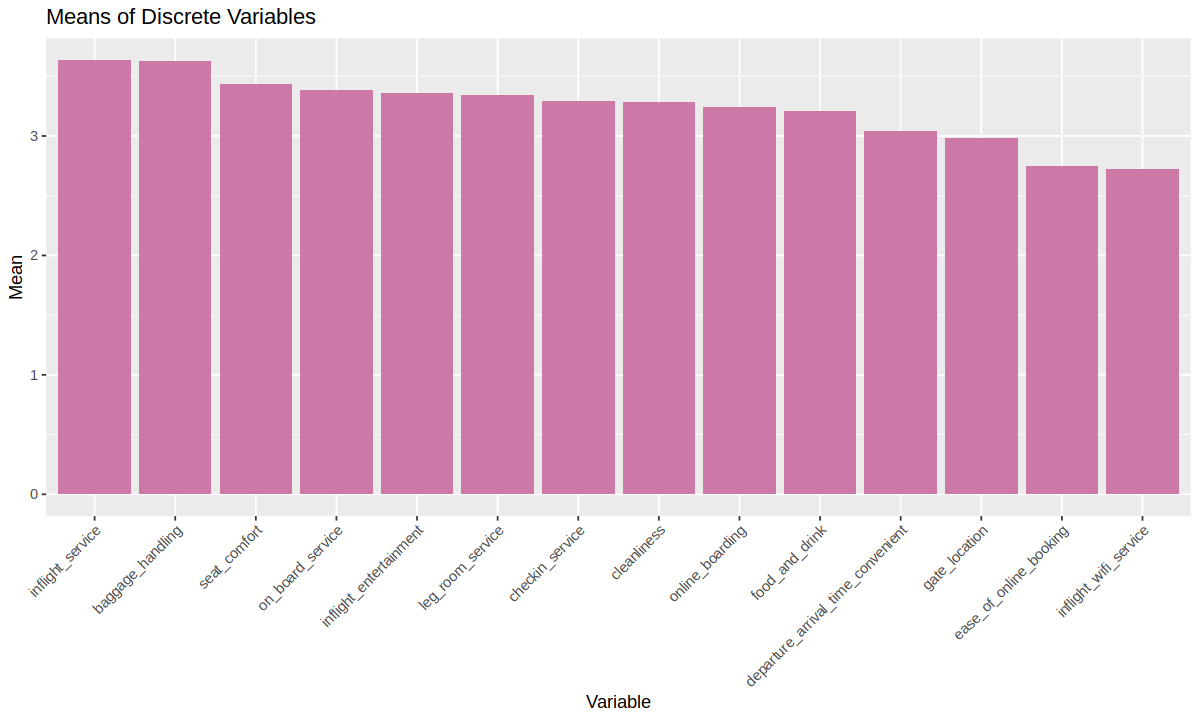

In [123]:
options(repr.plot.width = 10, repr.plot.height = 6)

means_graph <- airplane_means |>
            ggplot(aes(x = reorder(variable, -mean), y = mean)) +
            geom_bar(stat = "identity", position = "dodge", fill = "#CC79A7") +
            labs(x = "Variable", y = "Mean") + 
            theme(axis.text.x = element_text(angle= 45, hjust= 1)) +
            ggtitle("Means of Discrete Variables")

means_graph

<font size= '2'> **Figure 1:** A bar plot showing the means of each discrete predictor variable arranged in descending order by mean

As indicated by **Table 5** and **Figure 1**, it looks like passengers were on average most satisfied with the airline's `inflight_service`, `baggage_handling`, and `seat_comfort`. 

However, it looks like the variables all have relatively similar means as the bar heights are similar to each other. Nevertheless, we are only choosing the top 3 variables (`inflight_service`, `baggage_handling`, and `seat_comfort`) to ensure that our k-nn analysis is does not have too many predictors. 

<mark> **TODO: Potentially include citation about how these are generally more important than other predictors???**<mark> 

Now that we've looked at the discrete variables, what about the remaining continuous variables? Again, we used the `map_df()` function to help us find the means of the `departure_delay_in_minutes` and `arrival_delay_in_minutes` variables.

In [124]:
airplane_means_continous <- airplane_train |>
    select(-satisfaction) |>
    map_df(mean)   
airplane_means_continous |>
    select(departure_delay_in_minutes, arrival_delay_in_minutes) |>
    pivot_longer(1:2, names_to = "variable", values_to = "mean") |>
    arrange(desc(mean))

variable                   mean    
1 arrival_delay_in_minutes   14.70857
2 departure_delay_in_minutes 14.33498

<font size= '2'> **Table 6:** The means of `arrival_delay_in_minutes` and `departure_delay_in_minutes` arranged in descending order by mean

It looks like the average arrival and departure delay are both ~14 minutes. To visualize the relationship between `arrival_delay_in_minutes` and `departure_delay_in_minutes` we created a scatterplot with `arrival_delay_in_minutes` on the x-axis and `departure_delay_in_minutes` on the y-axis. Observations that are classified as `satisfied` are coloured blue and are indicated by a circle marker. Alternatively, observations that are classified as `neutral or dissatisfied` are coloured orange and are indicated by a triangle marker. 

Warning message:
“Removed 74 rows containing missing values (`geom_point()`).”


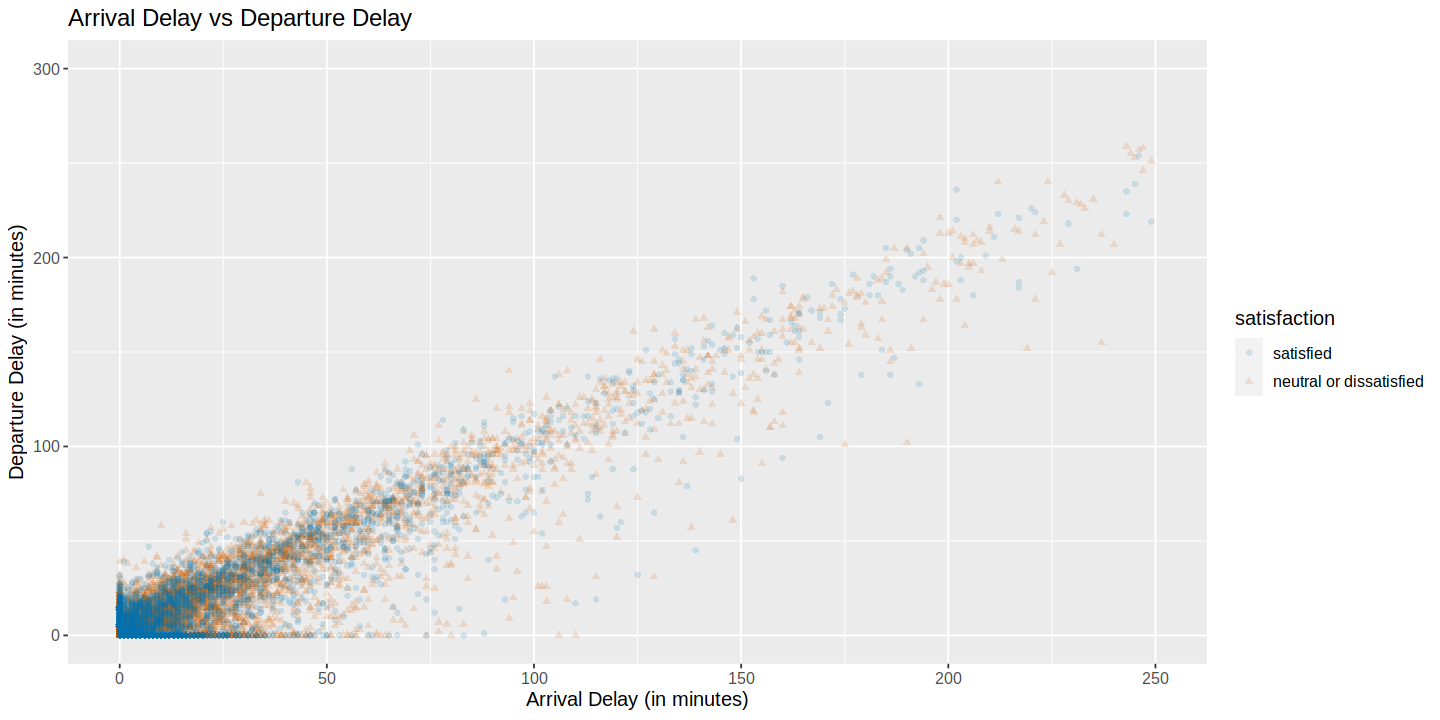

In [125]:
options(repr.plot.width = 12, repr.plot.height = 6)
arrival_departure_delay_plot <- airplane_train |>
                             ggplot(aes(x = arrival_delay_in_minutes, 
                                        y = departure_delay_in_minutes, 
                                        color = satisfaction, 
                                        shape = satisfaction)) +
                             geom_point(alpha = 0.15) + 
                             theme(text = element_text(size = 12)) +
                             labs(x = "Arrival Delay (in minutes)", y = "Departure Delay (in minutes)") + 
                             scale_color_manual(values = c("#0072B2", "#D55E00")) +
                             ggtitle("Arrival Delay vs Departure Delay") +
                             xlim(c(0,250)) +
                             ylim(c(0, 300))

arrival_departure_delay_plot

<font size= '2'> **Figure 2:** A scatterplot highlighting the relationship between `arrival_delay_in_minutes` coloured (and given a distinct shape) by `satisfaction`.

Based on **Figure 2**, we can see that most `satisfied` observations seem to cluster in the bottom left of the graph at 0 minutes of arrival and departure delay. Because most delays are within 100 minutes, we can see some overplotting in the bottom left of the graph. Nevertheless, as the departure and arrival delay increases, the number of `satisfied` observations decrease.

Indeed, irrespective of `satisfaction`, there is a slight positive relationship between arrival delay and departure delay such that as arrival delay increases, so does departure delay. This makes sense because if a plane were to depart later than it's intended departure time, it will naturally arrive later.


**Note:** by setting `xlim(c(0,250))` and `ylim(c(0, 300))`, some observations (specifically 74) were not plotted on the graph. This was done to ensure that the graph would be readable as some arrival and departure delays were extremely long and can be considered outliers.

Thus, based on our exploratory data analysis, we chose the following variables as our predictors for our k-nn analysis: 

- `inflight_service`
- `baggage_handling` 
- `seat_comfort`
- `arrival_delay_in_minutes`
- `departure_delay_in_minutes`

## Methods: Performing *K*-Nearest Neighbors Classification

### 1) Creating a recipe and the nearest_neighbors model specification for cross-validation

As part of building our classifier, we first preprocessed the airplane_train data by creating a recipe that standardizes the data. We then created our model specification setting `neighbors = tune())` since we will be first performing 10-fold cross validation to choose the best *K*.

In [126]:
airplane_recipe <- recipe(satisfaction ~ inflight_service + baggage_handling + seat_comfort + departure_delay_in_minutes + arrival_delay_in_minutes, 
                          data = airplane_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

### 2) Performing 10-fold cross validation to choose *K*

Below we used the `vfold_cv()` function to split our training data into 10 folds, stratifying by `satisfaction`. We set the seed to 1234 to ensure that we get the same folds everytime the code is run.

To actually perform the cross-validation, we first created a data frame `k_vals` containing values from 1 to 100. Next, we created a workflow passing `airplane_vfold` to the `resamples` argument and the`k_vals` dataframe to the `grid` argument of `tune_grid()`. We also added our recipe: `airplane_recipe` and model specification: `knn_spec_tune` into the workflow.

In [16]:
set.seed(1234)

airplane_vfold <- vfold_cv(airplane_train, v = 10, strata = satisfaction)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
               add_recipe(airplane_recipe) |>
               add_model(knn_spec_tune) |>
               tune_grid(resamples = airplane_vfold, grid = k_vals) |>
               collect_metrics()

accuracies <- knn_results |>
               filter(.metric == "accuracy") |>
               select(neighbors, mean) |>
               arrange(desc(mean))

head(accuracies)

neighbors mean     
1 26        0.6491111
2 21        0.6489050
3 31        0.6485447
4 36        0.6482358
5 41        0.6457136
6 46        0.6454046

<font size= '2'> **Table 7:** Estimated accuracy for a given number of neighbors arranged in descending order by `mean`.

By using `collect_metrics()` in our workflow, ADD TEXT 

**Table 7:** allows us to see the number of neighbors  ADD TEXT 

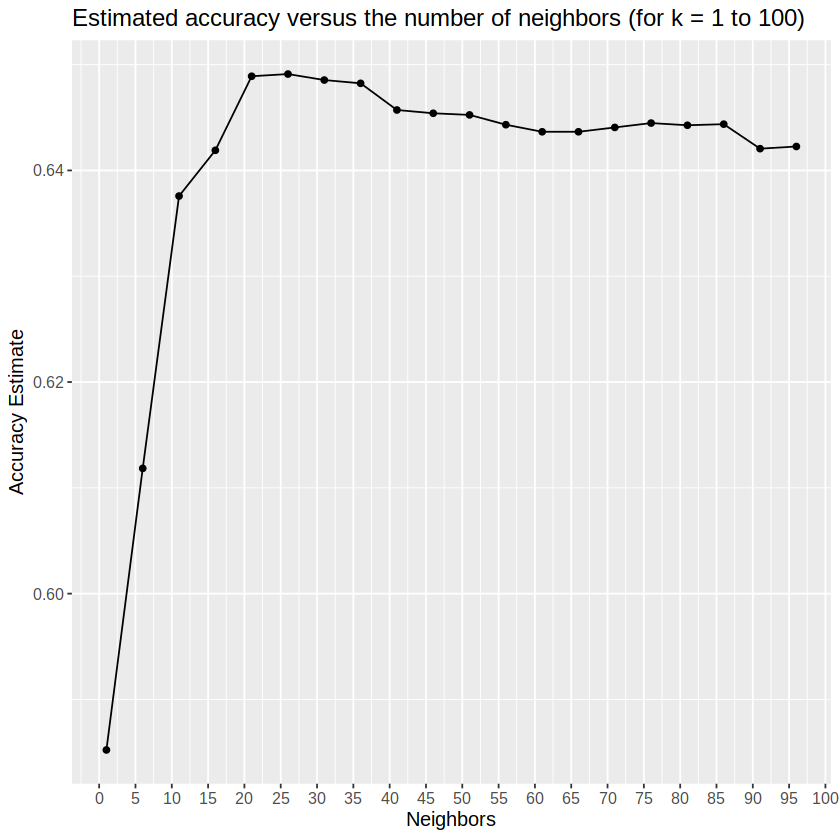

In [17]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                 geom_point() +
                 geom_line() + 
                 labs(x = "Neighbors", y = "Accuracy Estimate") +
                 ggtitle("Estimated accuracy versus the number of neighbors (for k = 1 to 100)") +
                 theme(text = element_text(size = 12)) + 
                 scale_x_continuous(breaks = seq(0, 100, by = 5))

accuracy_vs_k

<font size= '2'> **Figure 3:** A plot depicting the estimated accuracy versus the number of neighbors from 0 to 100. Based on the graph, it looks like *k* = 26 provides the highest accuracy estimate (~65%)

### 3) Predicting satisfaction in airplane_test 

With our *k* value chosen, we can create a new model specification called `knn_spec_best_k` which will specify that we want to run a k-nn analysis with 26 neighbors. We then added our new model specification, our `aiprlane_recipe` to a workflow (`knn_fit`) which is fitted to out `airplane_train` dataset. 

Finally, we included `knn_fit` in `predict()` to predict `satisfaction` for our `airplane_test` data. 

In [21]:
knn_spec_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) |>
                   set_engine("kknn") |>
                   set_mode("classification")

knn_fit <- workflow() |>
        add_recipe(airplane_recipe) |>
        add_model(knn_spec_best_k) |>
        fit(data = airplane_train)

airplane_test_predictions <- predict(knn_fit, airplane_test) |>
                          bind_cols(airplane_test)

### 4) Getting the prediction accuracy estimate for our classifier

To evaluate how well our classifier correctly predicted the `satisfaction` class on the test data, we used the `metrics()` function and set `truth = satisfaction` and `estiamte = .pred_class`. Filtering `.metric == "accuracy"` gives us the estimated prediction accuracy for our classifier. 

In this case, our accuracy estimate was ~63.49%. 

In [127]:
airplane_test_predictions |>
    metrics(truth = satisfaction, estimate = .pred_class) |>
    filter(.metric == "accuracy")

ERROR: Error in metrics(airplane_test_predictions, truth = satisfaction, estimate = .pred_class): object 'airplane_test_predictions' not found


<font size= '2'> **Table 8:** the estimated accuracy of our classifier on `airplane_test`

## Discussion

### 1) Summary of our K-nn Analysis

In [26]:
confusion_matrix <- airplane_test_predictions |>
                 conf_mat(truth = satisfaction, estimate = .pred_class)

confusion_matrix

                         Truth
Prediction                satisfied neutral or dissatisfied
  satisfied                     927                     497
  neutral or dissatisfied      1867                    3185

### 2) Evaluating Performance of our Classifier (Was this result what we expected to find?)

### 3) Impact of our findings

### 4) Future Questions

It is important to note that there are only two classes: `neutral or dissatisfied` or `satisfied`. As such, our data set groups together passengers who are **either** neutral *or* dissatisfied. Thus, there is no way to know the proportion of passengers that are **either** dissatisfied or neutral within the `neutral or dissatisfied` class. 

That being said, this distinction between neutral or dissatisfied might not be as important given that the results of our analysis would likely be used to improve upon airline experience. Thus, when evaluating upon airline services, the goal would be to ensure that most passengers are overall satisfied such that they aren't just neutral or (more importantly) dissatisfied with their experience.



^Something to potentially add in discussion

- might also be useful to Note weaknesses and strengths of k-nearest neighbors in the context of trying to answer our question 

## References